# World Temperature

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from math import *
from util import *

plt.rcParams["figure.figsize"] = (16, 9)

## Parseo de datos

In [4]:
df = pd.read_csv('data/worldTemperature.csv')

fechas = list(df['year'])
temps = list(df['temp'])

#res = cml(lambda x: [x*2, x], [1,2,3], [1,1,1])
#res(5)

## f(x) = w1\*x + w2\*1

0.163376334191


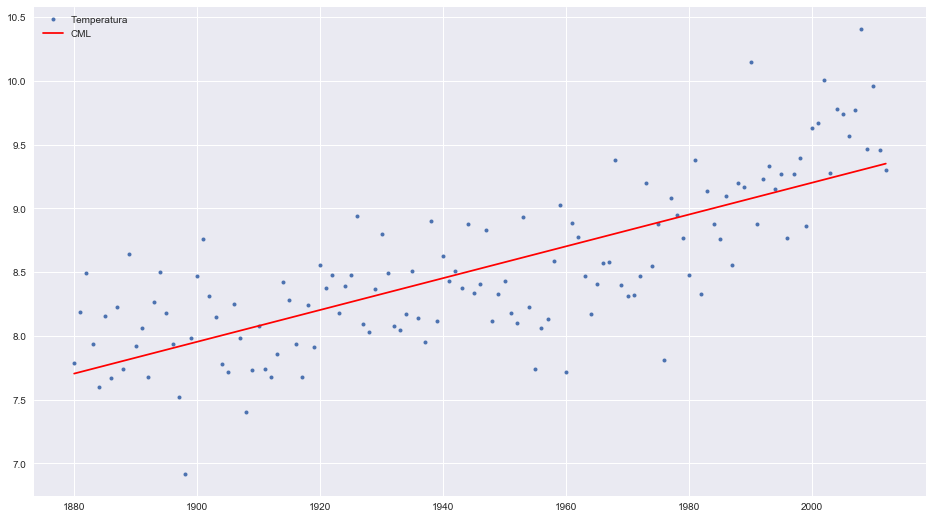

In [5]:
funcionCML = cml(lambda x: [x, 1], fechas, temps)
results = list(map(funcionCML, fechas))

plt.plot(fechas, temps, 'o', label='Temperatura', markersize=4)
plt.plot(fechas, results, 'r', label='CML')
plt.legend()
print(ecm(results, temps))

## f(x) = w1\*x^2 + w2\*x + w3\*1

0.132319040186


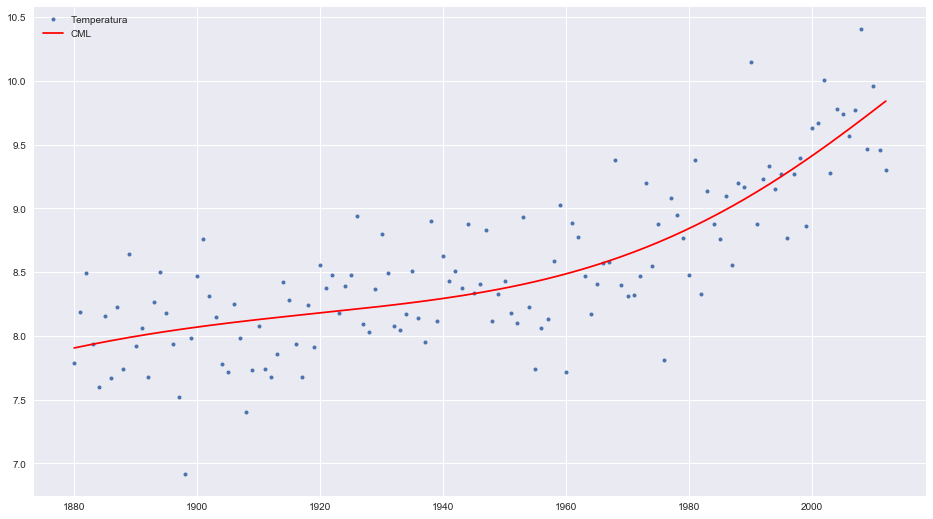

In [6]:
f = cml(poly(30), fechas, temps)
results = list(map(f, fechas))

plt.plot(fechas, temps, 'o', label='Temperatura', markersize=4)
plt.plot(fechas, results, 'r', label='CML')
plt.legend()
print(ecm(results, temps))

## f(x) con grado harcodeado

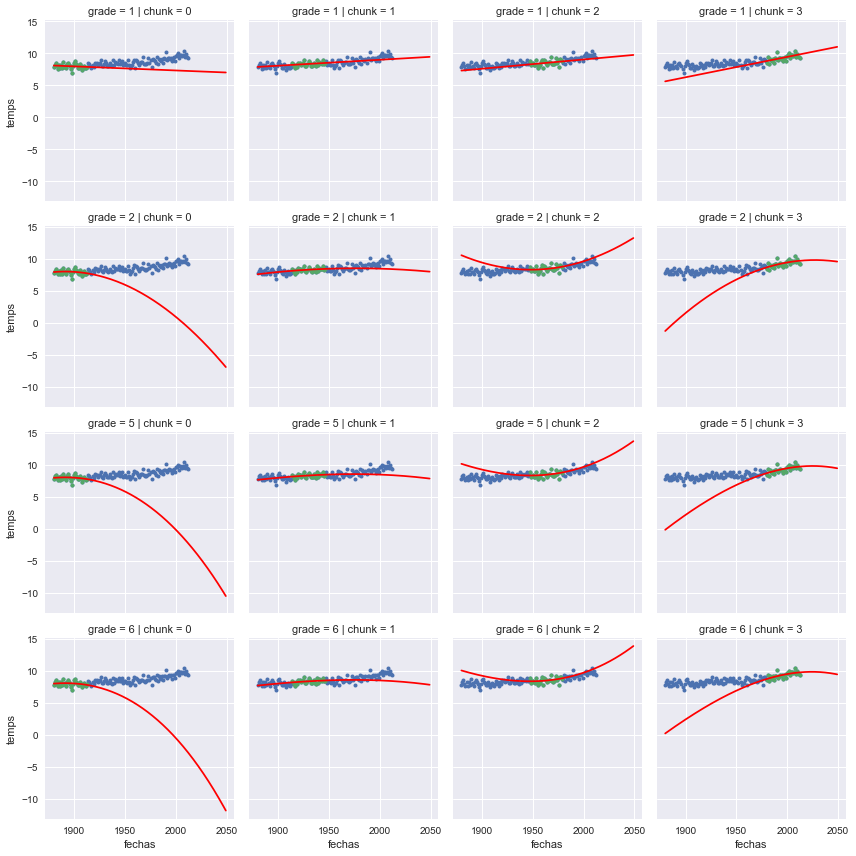

In [7]:
n = 66
lol = fechas + list(range(2013, 2050))
grados = [1, 2, 5, 6]
fechas_c = np.array_split(fechas, 4)
temps_c = np.array_split(temps, 4)
data = []
for g in grados:
    for c in range(4):
        f = cml(poly(g), fechas_c[c], temps_c[c])
        results = list(map(f, lol))
        data.append([results, g, c])

df2 = pd.DataFrame(data, columns=['x', 'grade', 'chunk'])

def pp(x, y, data, **kwargs):
    c = data['chunk'].values[0]
    plt.plot(fechas, temps, 'o', label='Temperatura', markersize=4)
    plt.plot(fechas_c[c], temps_c[c], 'o', label='Training', markersize=4)
    plt.plot(lol, data['x'].values[0], 'r', label='CML')
    plt.legend()
    
l = sns.FacetGrid(df2, col="chunk", row="grade", size=3)
l.map_dataframe(pp, 'fechas', 'temps')

# ECM vs Grado de polinomio

(0.13231904018632787, 30)


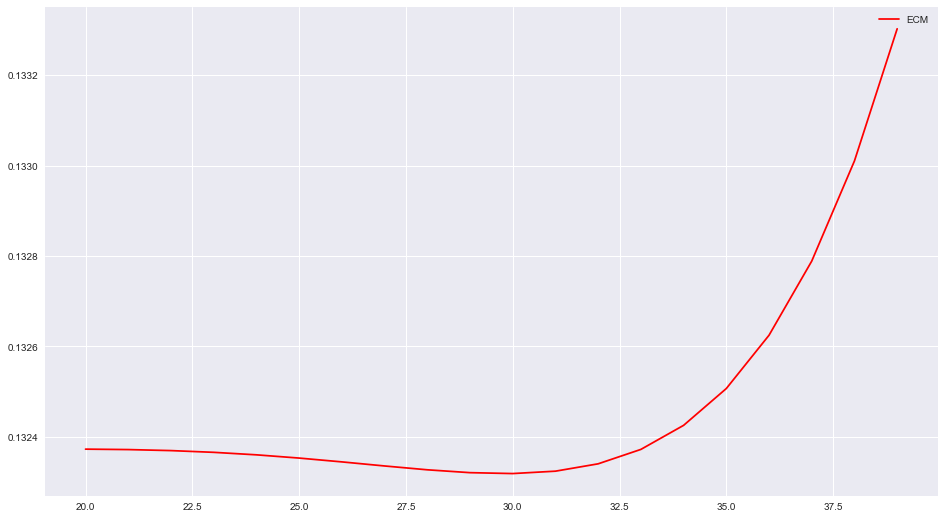

In [8]:
ecms = []

grados = range(20, 40, 1)
for grado in grados:
    f = cml(poly(grado), fechas, temps)
    results = list(map(f, fechas))
    ecms.append(ecm(results, temps))
    
m = min(zip(ecms, grados), key=lambda x: x[0])
print(m)

plt.plot(grados, ecms, 'r', label='ECM')
#plt.plot(fechas, results, 'r', label='CML')
plt.legend()

## Mido cuando comienza el calentamiento global

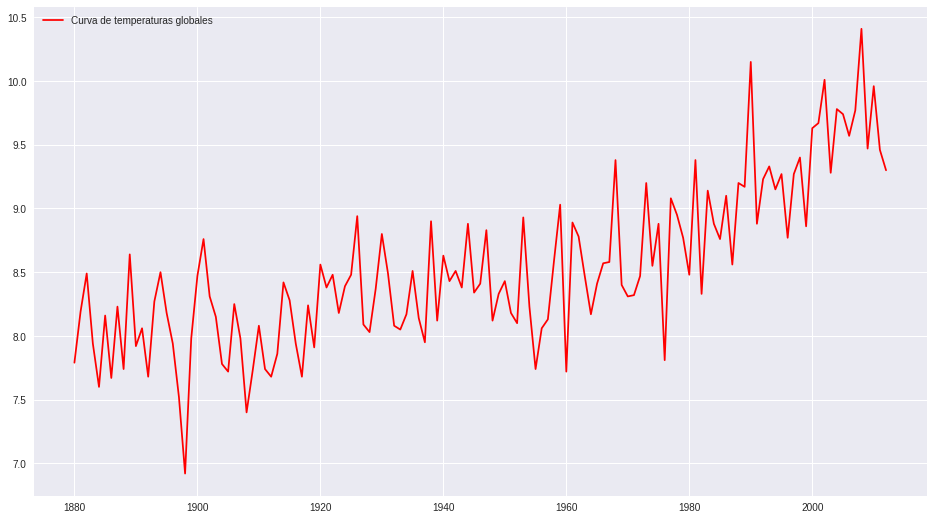

In [7]:
plt.plot(fechas, temps, 'r', label='Curva de temperaturas globales')
plt.legend()
plt.show()

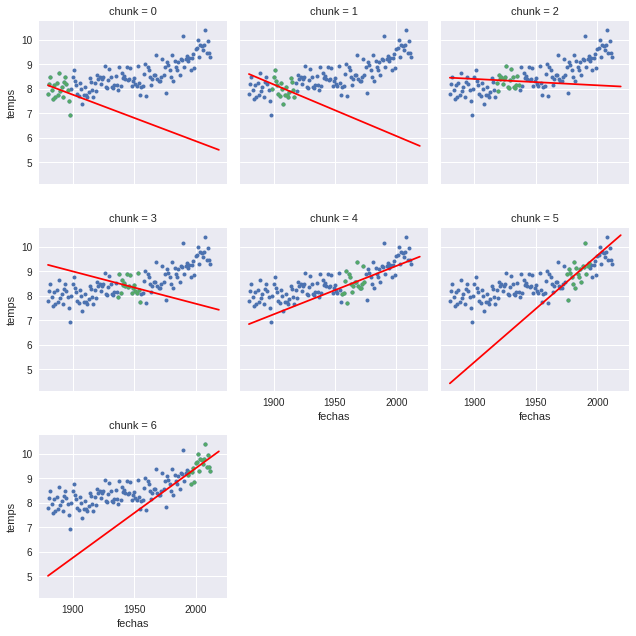

In [89]:
#Parto en 7 chuncks de 20 años (aprox) y veo las pendientes
fechasChunk = np.array_split(fechas,7)
tempChunk = np.array_split(temps,7)

lol = fechas + list(range(2013,2020))

data = []
for c in range(7):
    f = cml(poly(1), fechasChunk[c], tempChunk[c])
    results = list(map(f, lol))
    data.append([results, c])

df3 = pd.DataFrame(data, columns=['x', 'chunk'])

def pp(x, y, data, **kwargs):
    c = data['chunk'].values[0]
    plt.plot(fechas, temps, 'o', label='Temperatura', markersize=4)
    plt.plot(fechasChunk[c], tempChunk[c], 'o', label='Training', markersize=4)
    plt.plot(lol, data['x'].values[0], 'r', label='CML')
    plt.legend()

l = sns.FacetGrid(df3, col="chunk", col_wrap = 3)
l.map_dataframe(pp, 'fechas', 'temps')